## Import the necessary libraries

In [20]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [21]:
df = pd.read_csv('AMV Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"3,200.0","3,300.0","3,300.0","3,000.0",2.53M,-3.03%
1,04/16/2024,"3,300.0","3,300.0","3,400.0","3,100.0",1.31M,0.00%
2,04/15/2024,"3,300.0","3,500.0","3,600.0","3,300.0",1.28M,-5.71%
3,04/12/2024,"3,500.0","3,500.0","3,600.0","3,500.0",840.38K,0.00%
4,04/11/2024,"3,500.0","3,500.0","3,600.0","3,500.0",587.87K,0.00%
5,04/10/2024,"3,500.0","3,500.0","3,600.0","3,500.0",324.14K,0.00%
6,04/09/2024,"3,500.0","3,600.0","3,700.0","3,400.0",2.18M,-2.78%
7,04/08/2024,"3,600.0","3,600.0","3,700.0","3,600.0",703.91K,0.00%
8,04/05/2024,"3,600.0","3,700.0","3,700.0","3,500.0",3.40M,-5.26%
9,04/04/2024,"3,800.0","3,800.0","3,900.0","3,700.0",867.30K,0.00%


## Data preprocessing

In [22]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [23]:
# Show Dataframe
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,17072.0,17071.7,17117.0,16936.5,181.74K,-0.26%
2019-01-03,16982.0,17026.6,17027.0,16215.8,259.31K,-0.53%
2019-01-04,16666.0,16666.3,16801.0,16576.2,86.63K,-1.86%
2019-01-07,16171.0,16576.2,16576.0,16080.7,102.90K,-2.97%
2019-01-08,16171.0,16260.9,16261.0,16080.7,33.59K,0.00%
...,...,...,...,...,...,...
2024-04-11,3500.0,3500.0,3600.0,3500.0,587.87K,0.00%
2024-04-12,3500.0,3500.0,3600.0,3500.0,840.38K,0.00%
2024-04-15,3300.0,3500.0,3600.0,3300.0,1.28M,-5.71%


## Scale Data

In [24]:
# Select 'Close' column
data = df['Price'].values

In [25]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [26]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test, and validation sets
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size + val_size]
test_data = data_scaled[train_size + val_size:]

## Create and add data into X, y

In [27]:
# Function to prepare data for LSTM
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [28]:
# Prepare sequences
sequence_length = 60
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:]

val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_val, y_val = add_data(val_data_extended, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [29]:
# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build Model

In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Model

In [31]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
28/28 - 12s - loss: 0.0736 - val_loss: 0.0464 - 12s/epoch - 439ms/step
Epoch 2/50
28/28 - 3s - loss: 0.0158 - val_loss: 0.0112 - 3s/epoch - 105ms/step
Epoch 3/50
28/28 - 3s - loss: 0.0114 - val_loss: 0.0027 - 3s/epoch - 94ms/step
Epoch 4/50
28/28 - 3s - loss: 0.0227 - val_loss: 0.0214 - 3s/epoch - 95ms/step
Epoch 5/50
28/28 - 3s - loss: 0.0113 - val_loss: 0.0056 - 3s/epoch - 99ms/step
Epoch 6/50
28/28 - 4s - loss: 0.0108 - val_loss: 0.0030 - 4s/epoch - 138ms/step
Epoch 7/50
28/28 - 3s - loss: 0.0102 - val_loss: 0.0020 - 3s/epoch - 94ms/step
Epoch 8/50
28/28 - 3s - loss: 0.0089 - val_loss: 0.0030 - 3s/epoch - 95ms/step
Epoch 9/50
28/28 - 3s - loss: 0.0096 - val_loss: 0.0037 - 3s/epoch - 95ms/step
Epoch 10/50
28/28 - 4s - loss: 0.0093 - val_loss: 0.0019 - 4s/epoch - 127ms/step
Epoch 11/50
28/28 - 3s - loss: 0.0097 - val_loss: 0.0018 - 3s/epoch - 108ms/step
Epoch 12/50
28/28 - 3s - loss: 0.0079 - val_loss: 7.2733e-04 - 3s/epoch - 95ms/step
Epoch 13/50
28/28 - 3s - loss: 0.0111 

## Predict Close price in test and validation set

In [32]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 28ms/step


## Transform data back to the original

In [33]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [34]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 67144.37354151272
RMSE on Test set: 4406.941686883136
MSLE on Test set: 69.05922197450612


In [35]:
# The error in validation set
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: {val_mape}")
print(f"RMSE on Validate set: {val_rmse}")
print(f"MSLE on Validate set: {val_msle}")

MAPE on Validate set: 0.09007278787553663
RMSE on Validate set: 471.82932852179323
MSLE on Validate set: 0.011382784334492364


## Predict Close price for 30 next days

In [36]:
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    next_day_pred = model.predict(last_sequence_days)
    y_next_30_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 [==============================] - 0s 29ms/step


In [37]:
# Show the result of predict 30 next days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[3598.0354 3554.6804 3528.3623 3521.4941 3531.4246 3553.089  3581.3
 3612.042  3642.8362 3672.527  3700.8403 3727.947  3754.1538 3779.7344
 3804.8643 3829.631  3854.0603 3878.1567 3901.9216 3925.3687 3948.5198
 3971.4092 3994.076  4016.554  4038.876  4061.0718 4083.1638 4105.1694
 4127.1035 4148.979 ]


## Model visualization

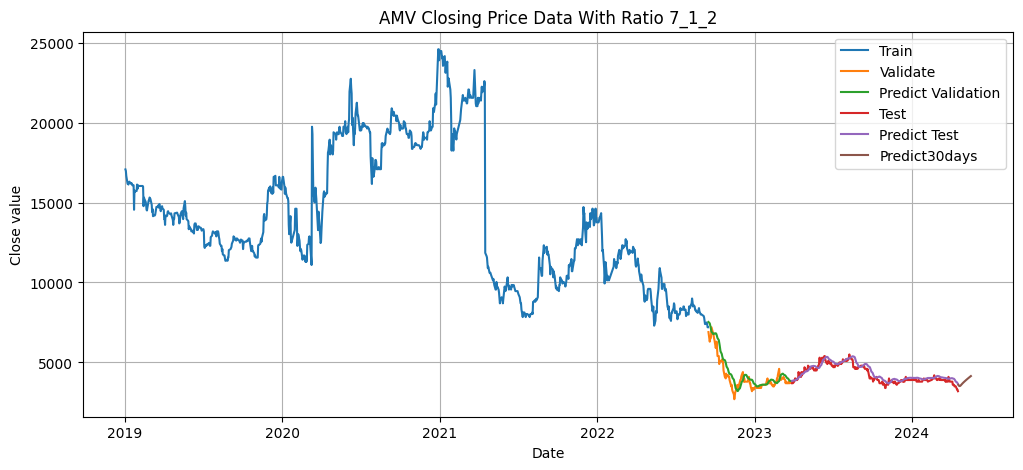

In [38]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df[:train_size].index, train_data)
plt.plot(df[train_size:train_size + val_size].index, val_data)
plt.plot(df[train_size:train_size + val_size].index, y_pred_val)
plt.plot(df[train_size + val_size:].index, test_data)
plt.plot(df[train_size + val_size:].index, y_pred)
plt.plot(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), y_next_30_days)
plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("AMV Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_AMV.png')
plt.show()